In [9]:
import occultation_package as occ
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline
import matplotlib.backends.backend_pdf

817


/Users/jjri6482/miniconda3/envs/sorce_occ/lib/python3.8/site-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jjri6482/miniconda3/envs/sorce_occ/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/jjri6482/miniconda3/envs/sorce_occ/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


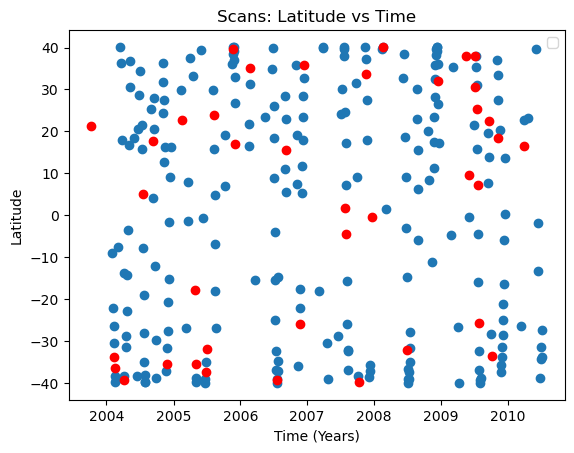

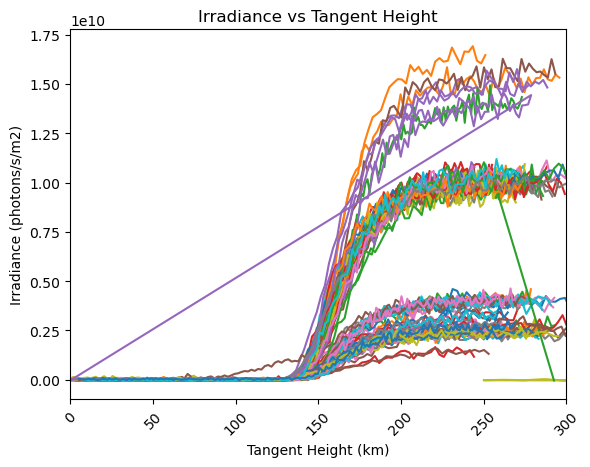

In [10]:
#Holds a list of column density arrays
density_profiles = []
#Holds a list of smoothed density arrays
smoothed_density_profiles = []
#Holds a list of height arrays
height_profiles = []
#A list of file names
file_id = []
#A list of heights
height = []
#A list of column densities
cd = []
#Residual values in a list
residuals = []
#Median Irradiance
med_irr = []
#Top half of irradiance files
top_half_irr = []
#Top quarter of irradiance files
top_quarter_irr = []
#Bottom half of irradiance files
bottom_half_irr = []
#Extinction ratios
ratio = []
#List of indexes where the extinction ratio is within a specified range
er_range = []
#Column Density Uncertainties
density_uncertainty = []
#Holds a list of density uncertainties
uncertainty_profiles = []
#Holds a list of times
date_time = []
#Holds a list of local times
local_date_time = []
#Holds a list of lattitudes 
lat = []
#Holds a list of longitdues 
lon = []
#Holds a list of times for the scans with waves
date_time_waves = []
#Holds a list of local times for the scans with waves
date_local_time_waves = []
#Holds a list of lattitudes for the scans with waves
lat_waves = []
#Holds a list of longitudes for the scans with waves
lon_waves = []
#Holds a list of star names for each scan
star_names = []

#Makes the multi_files readable
multi_files = open('scans_with_multiple_occultation.txt')
ms = multi_files.readlines()
ms = [i.strip('\n') for i in ms]

#The length of files list in the occultation package
num_occ = len(occ.files)
print(num_occ)


scans_with_waves = [9, 99, 70, 62, 58, 55, 53, 49, 48, 38, 34, 26, 269, 263, 261, 260, 257, 254, 252, 249, 245, 238, 209, 208, 204, 186, 185, 177, 168, 142, 139, 135, 12, 129, 127, 122, 120, 102, 101]


#Basic averaging function
def Average(lst):
    return sum(lst) / len(lst)

for i in range(num_occ):
    if occ.files[i].name in ms:
        pass
    else:   
        #Runs the get_cd function and stores the height, column density, smoothed column density, and extinction ratio
        density = occ.get_cd(occ.files[i], plot = (i % 2000 == 0))
        ratio = density[4]
        cd = density[0]
        smoothed_cd = density[5]
        height = density[1]
        density_uncertainty = density[6]
        time = density[2]
        lattitude = density[7]
        longitude = density[8]
        local = (time.timestamp()+longitude)/(15)
        #star = density[8]
        
        if len(height) == 0:
            pass
        else:
            #Uses the extinction ratio to find the indexes within a specifed range, this will vary for each iteration
            er_range = np.where((ratio > 0.1) & (ratio < 0.90))
            height = height[er_range]
            cd = cd[er_range]
            smoothed_cd = smoothed_cd[er_range]
            density_uncertainty = density_uncertainty[er_range]
            #time = time[er_range]
            #lattitude = lattitude[er_range]
            occ.irr_height(occ.files[i], plot = (i % 4000 == 0))
            med_irr.append(np.median(occ.irradiance(occ.files[i])))
            density_profiles.append(cd)
            smoothed_density_profiles.append(smoothed_cd)
            height_profiles.append(height)
            uncertainty_profiles.append(density_uncertainty)
            #star_names.append(star)
            
            if i in scans_with_waves:
                date_time_waves.append(time)
                lat_waves.append(lattitude)
                lon_waves.append(longitude)
                date_local_time_waves.append(local)
            else:
                date_time.append(time)
                lat.append(lattitude)
                lon.append(longitude)
                local_date_time.append(local)
            file_id.append(occ.files[i].name)
        


for i in range(len(med_irr)):
    if (med_irr[i] >= Average(med_irr)):
        top_half_irr.append(med_irr[i])
    else:
        bottom_half_irr.append(med_irr[i])    
        
for i in range(len(top_half_irr)):
    if top_half_irr[i] >= Average(top_half_irr):
        top_quarter_irr.append(top_half_irr[i])

plt.figure()
plt.scatter(date_time, lat)
plt.scatter(date_time_waves, lat_waves, color = 'red')
plt.title('Scans: Latitude vs Time')
plt.legend()
plt.xlabel('Time (Years)')
plt.ylabel('Latitude')
plt.show()

'''plt.figure()
plt.scatter(date_time, local_date_time)
plt.scatter(date_time_waves, date_local_time_waves, color = 'red')
plt.title('Scans: Local Time vs UTC')
plt.legend()
plt.xlabel('Time (Years)')
plt.ylabel('Local Time')
plt.show()'''

for i in range(len(med_irr)):
    if occ.files[i].name in ms:
        pass
    else:
        occ.irr_height(occ.files[i], plot = True) 


In [11]:
for i in range(num_occ):
    if occ.files[i].name in ms:
            pass
    elif height_profiles[i].any() == (0.0):
            pass
    else:
        #Plots the data and the fitted function
        plt.figure()

        m, o = np.polyfit(height_profiles[i], np.log(smoothed_density_profiles[i]), 1)

        model_fit = np.exp(o) * np.exp(m*height_profiles[i])

        plt.plot(height_profiles[i], smoothed_density_profiles[i], label = 'Data')
        plt.plot(height_profiles[i], model_fit, label = 'Model Fit')

        plt.errorbar(height_profiles[i], smoothed_density_profiles[i], yerr = uncertainty_profiles[i])

        plt.yscale('log')
        plt.xlabel('Tangent Height (km)')
        plt.ylabel('Smoothed Column Density (cm-2)')
        plt.title('Smoothed Column Density Vs. Tangent HeightScan ' + ' ' + str(i))
        plt.legend()
        plt.grid()
        #plt.show()
        plt.savefig('output-graphs/' + str(i) + 'Column Density Vs. Tangent Height.png')
        plt.close()

        #Calculates residuals, data at a point - fitted function at that point
        residuals = smoothed_density_profiles[i] - model_fit 

        #res_uncertanties = (residuals*uncertainty_profiles[i])/smoothed_density_profiles[i]
        
        oscillation_data = np.asarray([residuals, height_profiles[i], uncertainty_profiles[i]])
        np.savetxt('output-spreadsheets/' + str(i) + 'oscillation_data.csv', oscillation_data, delimiter=",")
        
        #Plots scatter plots of the two residuals
        plt.figure()
        plt.scatter(height_profiles[i], (residuals/model_fit), label = 'Linear Residuals')
        plt.errorbar(height_profiles[i], (residuals/model_fit), yerr = np.absolute(uncertainty_profiles[i])/(model_fit))
        plt.ylabel('Residuals (Column Density - Model)')
        plt.xlabel('Tangent Height (km)')
        plt.title('Scatter plot Residuals Vs. Tangent Height Scan ' + ' ' + str(i))
        plt.grid()
        plt.legend()
        #plt.show()
        plt.savefig('output-graphs/' + str(i) + 'Scatter plot Residuals Vs. Tangent Height.png')
        plt.close()

           



IndexError: list index out of range